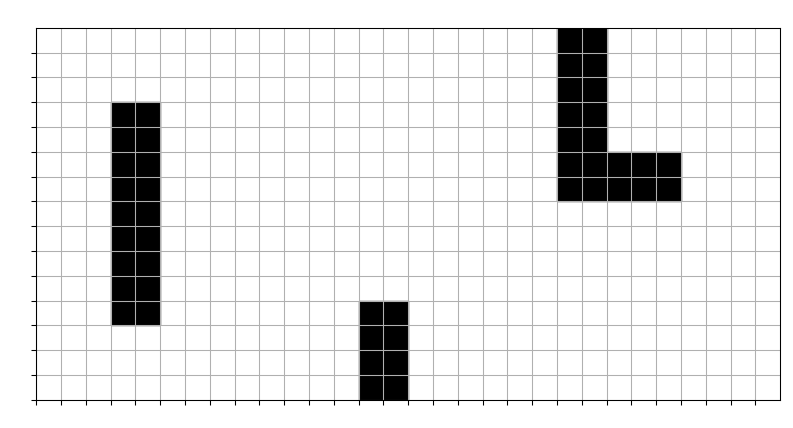

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from envSetup import EnvSetup
from customizedShape import CustomizedShape
from pathfinder import Pathfinder



# Fixing random state for reproducibility
np.random.seed(EnvSetup().seed)


# Create new Figure and an Axes which fills it.
fig = plt.figure(num="besiege", figsize=(10, 10), dpi=96, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)



# Map setup parameters -- Customized paramaters.
map_width = EnvSetup().map_width
map_height = EnvSetup().map_height
n_robot = EnvSetup().n_robot
n_target = EnvSetup().n_target


# Map robots setup.
# Deploy robots.
data_robot = np.zeros(n_robot, dtype=[('position', float, 2),
                                      ('color',    float, 4)])
# Deploy targets.
data_target = np.zeros(n_target, dtype=[('position', float, 2),
                                        ('color',    float, 4)])
# Deploy walls.
for shape in CustomizedShape().walls['shape']:
    ax.add_patch(shape)
# print(CustomizedShape().walls['position'])



# Construct the scatter which we will update during animation
# as time progess.
scatter_robot = ax.scatter(data_robot['position'][:, 0], data_robot['position'][:, 1],
                           s=256, lw=0.5, 
                           edgecolors=data_robot['color'], facecolors=data_robot['color'], 
                           marker=CustomizedShape().marker_robot)
scatter_target = ax.scatter(data_target['position'][:, 0], data_target['position'][:, 1],
                            s=256, lw=0.5, 
                            edgecolors=data_target['color'], facecolors=data_target['color'], 
                            marker=CustomizedShape().marker_target)
lines = []
    
    
    
#
def init():
    
    # Map Backgroud setup.
    ax.set_xlim(0-0.5, map_width-0.5)
    ax.set_ylim(0-0.5, map_height-0.5)
    ax.set_aspect('equal')    
    x_ticks = np.arange(0-0.5, map_width-0.5, 1)
    y_ticks = np.arange(0-0.5, map_height-0.5, 1)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Initialize data.
    # robot.
#     data_robot['position'] = np.around(np.random.uniform([0, 0], [map_width, map_height], (n_robot, 2)))
    data_robot['position'] = np.array(EnvSetup().nodes_robot_initializer)
    data_robot['color'] = np.repeat([[0., 1., 0., 1.]], n_robot, axis=0)
    # target.
#     data_target['position'][0] = np.around(np.asarray([[map_width*0.5, map_height*0.5]]))
    data_target['position'][0] = np.array(EnvSetup().nodes_target_initializer)
    data_target['color'] = np.repeat([[1., 0., 0., 1.]], n_target, axis=0)
    
    
# Generate the data randomly.
def data_generator_random(frame_number=0):
    
    threshold = 1e2
    step_x = 0.
    step_y = 0.
    
    while frame_number < threshold:
        # Get an index which we can use to re-spawn the oldest data.
        current_index_robot = frame_number % n_robot 

        # Pick a new position for oldest data.
        # robot.
        data_robot['position'][current_index_robot] = np.around(np.random.uniform([0+step_x, 0+step_y], [map_width-step_x, map_height-step_y], 2))
        # target.
        data_target['position'][0] = np.around(np.asarray([[map_width*0.5, map_height*0.5]]))
        # wall.
        

        # Update.
        frame_number += 1
        step_x += (map_width / 2 - 2) / (threshold)
        step_y += (map_height/ 2 - 2) / (threshold)
        
        yield data_robot, data_target    



#
def data_generator(frame_number=0):
#     pass
    pathfinderObject = Pathfinder()
    pathfinderObject.breadth_first_search()
    # path = [[path_robot_1], [path_robot_2], ..., [path_robot_n]]
    path = []
    path_x = []
    path_y = []
    for robot_i  in np.arange(n_robot):
        path.append(pathfinderObject.reconstruct_path(tuple(data_robot['position'][robot_i])))
        path_x.append([path[robot_i][ix][0] for ix in range(len(path[robot_i]))])
        path_y.append([path[robot_i][ix][1] for ix in range(len(path[robot_i]))])
    # Generate data_robot.
    while path != []:
        #
        lines.clear()
        for ix in np.arange(len(path_x)):
            lines.append(plt.plot(path_x[ix], path_y[ix], '--', lw=1))
        #
        for robot_i  in np.arange(n_robot):
            try:
                data_robot['position'][robot_i] = path[robot_i].pop()
            except IndexError:
                pass
        yield data_robot
    

#
def update(data):
    
    # Update the scatter collection, with the new colors and positions.
    # Update robots.
    scatter_robot.set_edgecolors(data_robot['color'])
    scatter_robot.set_facecolors(data_robot['color'])
    scatter_robot.set_offsets(data_robot['position'])
    # Update targets.
    scatter_target.set_edgecolors(data_target['color'])
    scatter_target.set_facecolors(data_target['color'])
    scatter_target.set_offsets(data_target['position'])
    


# Construct the animation, using the update function as the animation director.
ani = animation.FuncAnimation(fig, update, data_generator, interval=100, init_func=init,
                                   repeat=False)
plt.show()